<a href="https://colab.research.google.com/github/Sazar-1/Computational-Physics-Course/blob/main/Copy_of_Numerical_Solver_for_Radial_Schr%C3%B6dinger_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Numerical Solver for Radial Schrodinger Equation

--- Numerical Solver for Radial Schrödinger Equation ---
Note: This is a numerical approximation. The Nikiforov-Uvarov method is an analytical technique,
and a general Python implementation for arbitrary 'h' in V(r)=A/r^2-B/r+cr^h is not feasible.
This code provides approximate energy eigenvalues and wavefunctions.

Searching for eigenvalues for potential V(r) = 0.5/r^2 - 1.0/r + 0.1r^2.0, l=0
Radial range: [1e-05, 15.0]
  Attempting to solve for E_guess = -0.300000...
    Converged! Found a potential eigenvalue at E = 1.311357
  Attempting to solve for E_guess = -0.291379...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.282759...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.274138...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.265517...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.256897...


<ipython-input-20-998a07ae8a74>:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm_const_sq = np.trapz(u_r**2, r_mesh)


    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.248276...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.239655...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.231034...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.222414...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.213793...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.205172...
    solve_bvp failed to converge for E = -0.205172: The maximum number of mesh nodes is exceeded.
  Attempting to solve for E_guess = -0.196552...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.187931...
    E = 1.311357 is a duplicate, skipping.
  Attempting to solve for E_guess = -0.179310...
    solve_bvp failed to converge for E = -0.179310: The maximum number of mesh nodes is exceeded.
  Attempting to sol

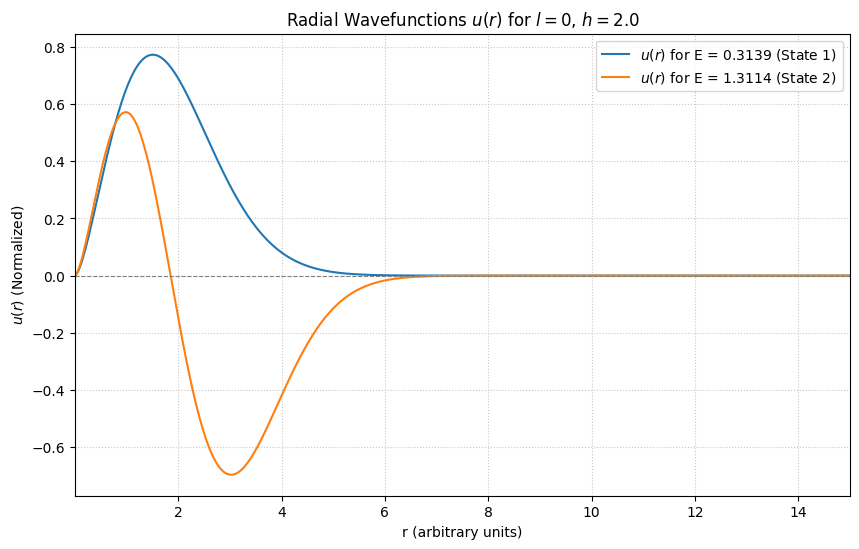

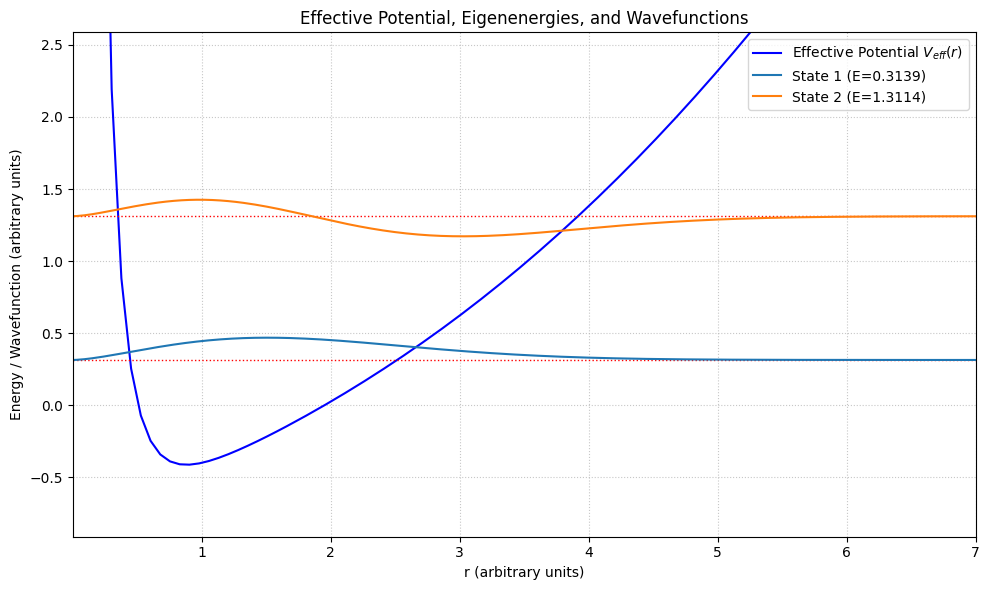


--- Numerical Solver Execution Complete ---


In [ ]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
# --- Physical Constants (can be adjusted) ---
# Using natural units for simplicity (hbar=1, mu=1)
# You can set these to their actual physical values if needed.
HBAR = 1.0  # Reduced Planck constant
MU = 1.0    # Reduced mass of the particle

# --- Potential Definition ---
def potential(r, A, B, c, h):
    """
    Defines the potential V(r) = A/r^2 - B/r + c*r^h.
    Handles r near zero to prevent division by zero for inverse power terms.
    """
    # Use a small epsilon to ensure r is never exactly zero,
    # which would cause issues with 1/r^2 and 1/r terms.
    r_safe = np.maximum(r, 1e-10)

    term_A = A / r_safe**2
    term_B = -B / r_safe
    term_C = c * r_safe**h

    return term_A + term_B + term_C

def effective_potential(r, A, B, c, h, l):
    """
    Calculates the effective potential V_eff(r) = V(r) + hbar^2 * l(l+1) / (2 * mu * r^2).
    This includes the centrifugal barrier term.
    """
    # Centrifugal term
    centrifugal_term = (HBAR**2 * l * (l + 1)) / (2 * MU * r**2)
    return potential(r, A, B, c, h) + centrifugal_term

# --- Boundary Value Problem (BVP) Functions for scipy.integrate.solve_bvp ---

def fun(r, y, p):
    """
    Defines the right-hand side of the system of first-order ODEs.
    The radial Schrödinger equation: d^2u/dr^2 + (2*mu/hbar^2) * (E - V_eff) * u(r) = 0
    is converted into a system:
    y[0]' = y[1]  (where y[0] = u(r))
    y[1]' = -(2*mu/hbar**2) * (E - V_eff) * y[0] (where y[1] = u'(r))

    Parameters:
    r (float): Radial coordinate.
    y (ndarray): Array containing [u(r), u'(r)].
    p (ndarray): Array containing parameters. Here, p[0] = E (energy eigenvalue).
    """
    E = p[0]
    # Potential parameters and angular momentum are passed via a closure (fun.params)
    A_val, B_val, c_val, h_val, l_val = fun.params

    V_eff_val = effective_potential(r, A_val, B_val, c_val, h_val, l_val)

    # Calculate d^2u/dr^2
    d2u_dr2 = -(2 * MU / HBAR**2) * (E - V_eff_val) * y[0]

    return np.vstack([y[1], d2u_dr2])

def bc(ya, yb, p):
    """
    Defines the boundary conditions for the BVP.
    For bound states, we require the radial wavefunction u(r) to be zero at:
    1. r_min (effectively r=0)
    2. r_max (effectively r=infinity)
    3. An additional scaling condition, e.g., u'(r_min) = 1. This is necessary
       because solve_bvp expects (number of ODEs + number of parameters) conditions.

    Parameters:
    ya (ndarray): Values of y at r_min ([u(r_min), u'(r_min)]).
    yb (ndarray): Values of y at r_max ([u(r_max), u'(r_max)]).
    p (ndarray): Array containing parameters (p[0] = E).
    """
    return np.array([
        ya[0],      # u(r_min) = 0
        yb[0],      # u(r_max) = 0
        ya[1] - 1.0 # u'(r_min) = 1.0 (arbitrary scaling condition to fix amplitude)
    ])

# --- Numerical Solver Function ---
def solve_schrodinger_numerical(A, B, c, h, l, r_min, r_max, num_points, E_guesses):
    """
    Numerically solves the radial Schrödinger equation for given potential parameters
    and searches for energy eigenvalues within a specified range.

    Parameters:
    A, B, c, h (float): Parameters for the potential V(r).
    l (int): Orbital angular momentum quantum number.
    r_min (float): Minimum radial distance for the numerical grid (must be > 0).
    r_max (float): Maximum radial distance for the numerical grid (should be large enough for decay).
    num_points (int): Number of grid points for the radial mesh.
    E_guesses (list or ndarray): Initial energy values to try for finding eigenvalues.
                                 These should bracket the true eigenvalues.

    Returns:
    tuple: A tuple containing:
        - list of found eigenvalues.
        - list of tuples (r_mesh, normalized_wavefunction) for each eigenvalue.
    """
    eigenvalues = []
    eigenfunctions = []
    # Tolerance for checking if an eigenvalue is already found
    EIGENVALUE_TOLERANCE = 1e-5

    print(f"Searching for eigenvalues for potential V(r) = {A}/r^2 - {B}/r + {c}r^{h}, l={l}")
    print(f"Radial range: [{r_min}, {r_max}]")

    # Create the radial mesh
    r_mesh = np.linspace(r_min, r_max, num_points)

    # Initial guess for the solution y(r) = [u(r), u'(r)]
    # A more physically motivated initial guess for u(r) (ground state)
    # It should be zero at boundaries and peak somewhere in the middle of the well.
    y_guess = np.zeros((2, r_mesh.size))

    # Use a simple sine wave for u(r) as an initial guess for the ground state.
    # This shape naturally satisfies u(r_min)=0 and u(r_max)=0.
    y_guess[0, :] = np.sin(np.pi * (r_mesh - r_min) / (r_max - r_min))
    # Ensure it's exactly zero at boundaries due to floating point
    y_guess[0, 0] = 0.0
    y_guess[0, -1] = 0.0

    # Calculate the derivative numerically for the initial guess
    # This is crucial for the y[1] component of the guess.
    y_guess[1, :] = np.gradient(y_guess[0, :], r_mesh)

    # Apply the scaling condition for u'(r_min) = 1.0 to the initial guess.
    # This helps solve_bvp converge to a non-trivial solution that matches the bc.
    if np.abs(y_guess[1, 0]) > 1e-10: # Avoid division by zero if derivative is near zero
        scaling_factor = 1.0 / y_guess[1, 0]
        y_guess[0, :] *= scaling_factor
        y_guess[1, :] *= scaling_factor
    else:
        # If initial derivative is zero or very small, set it to 1.0 directly for the guess
        # This might happen if r_min is very close to a peak/trough of the sine wave.
        y_guess[1, 0] = 1.0


    # Pass potential parameters to the 'fun' function via its attribute
    fun.params = (A, B, c, h, l)

    # Iterate through energy guesses to find eigenvalues
    for E_guess in E_guesses:
        print(f"  Attempting to solve for E_guess = {E_guess:.6f}...")
        try:
            # Solve the boundary value problem
            # p=[E_guess] provides the initial guess for the parameter E
            sol = solve_bvp(fun, bc, r_mesh, y_guess, p=[E_guess])

            if sol.success:
                # Check if the boundary condition at r_max is sufficiently met.
                bc_met_tolerance = 1e-6 # Tolerance for u(r_max) to be considered zero
                if np.abs(sol.sol(r_max)[0]) < bc_met_tolerance:
                    found_E = sol.p[0]

                    # Check if this eigenvalue is already found (within tolerance)
                    is_duplicate = False
                    for existing_E in eigenvalues:
                        if np.isclose(found_E, existing_E, atol=EIGENVALUE_TOLERANCE):
                            is_duplicate = True
                            break

                    if not is_duplicate:
                        print(f"    Converged! Found a potential eigenvalue at E = {found_E:.6f}")
                        eigenvalues.append(found_E) # The refined eigenvalue from solve_bvp

                        # Extract and normalize the wavefunction
                        u_r = sol.sol(r_mesh)[0]
                        # Calculate normalization constant (integral of |u(r)|^2 dr)
                        norm_const_sq = np.trapz(u_r**2, r_mesh)

                        if norm_const_sq > 1e-10: # Avoid division by zero for normalization
                            u_normalized = u_r / np.sqrt(norm_const_sq)
                            eigenfunctions.append((r_mesh, u_normalized))
                        else:
                            print("      Warning: Wavefunction too small for normalization. Appending unnormalized.")
                            eigenfunctions.append((r_mesh, u_r))
                    else:
                        print(f"    E = {found_E:.6f} is a duplicate, skipping.")
                else:
                    print(f"    E = {E_guess:.6f} did not meet boundary condition (u(r_max) = {sol.sol(r_max)[0]:.2e})")
            else:
                print(f"    solve_bvp failed to converge for E = {E_guess:.6f}: {sol.message}")
        except Exception as e:
            print(f"    An error occurred during solution for E = {E_guess:.6f}: {e}")

    return eigenvalues, eigenfunctions

# --- Main Execution Block ---
if __name__ == "__main__":
    print("--- Numerical Solver for Radial Schrödinger Equation ---")
    print("Note: This is a numerical approximation. The Nikiforov-Uvarov method is an analytical technique,")
    print("and a general Python implementation for arbitrary 'h' in V(r)=A/r^2-B/r+cr^h is not feasible.")
    print("This code provides approximate energy eigenvalues and wavefunctions.\n")

    # --- User-definable Parameters for the Potential and System ---
    A_param = 0.5  # Coefficient for 1/r^2 term
    B_param = 1.0  # Coefficient for 1/r term (e.g., Coulomb-like)
    c_param = 0.1  # Coefficient for r^h term
    h_param = 2.0  # Exponent for r^h term (e.g., h=2 gives a harmonic oscillator-like term)
                   # Try changing h to 0, -1, or -2 to see how it affects the potential.
    l_param = 0    # Orbital angular momentum quantum number (l=0 for s-wave)

    # --- Numerical Grid Parameters ---
    r_min_val = 1e-5  # Minimum radial distance (must be > 0 to avoid singularities)
    r_max_val = 15.0  # Maximum radial distance (needs to be large enough for wavefunction decay)
    num_points_val = 500 # Number of points in the radial mesh (higher for better accuracy)

    # --- Energy Guesses ---
    # This is the most critical part for finding eigenvalues.
    # For bound states, energy 'E' must be negative.
    # The range of guesses should ideally bracket the true eigenvalues.
    # For a hydrogen-like potential (-B/r), the ground state energy is roughly -B^2 * MU / (2 * HBAR^2).
    # The other terms (A/r^2, c*r^h) will shift this.
    # Based on a quick plot of the effective potential for the given parameters,
    # the minimum is around -0.2 to -0.3. So, let's target this range.
    energy_guesses = np.linspace(-0.3, -0.05, 30) # Refined example range of energy guesses

    # --- Run the Numerical Solver ---
    eigenvalues, eigenfunctions = solve_schrodinger_numerical(
        A_param, B_param, c_param, h_param, l_param,
        r_min_val, r_max_val, num_points_val, energy_guesses
    )

    # --- Plotting Results ---
    if eigenvalues:
        print("\n--- Plotting Found Eigenvalues and Wavefunctions ---")
        # Sort eigenvalues for consistent plotting order
        sorted_indices = np.argsort(eigenvalues)
        sorted_eigenvalues = [eigenvalues[i] for i in sorted_indices]
        sorted_eigenfunctions = [eigenfunctions[i] for i in sorted_indices]

        # --- Plot all radial wavefunctions on a single figure (original style) ---
        plt.figure(figsize=(10, 6))
        for i, E_val in enumerate(sorted_eigenvalues):
            r_plot, u_plot = sorted_eigenfunctions[i]
            plt.plot(r_plot, u_plot, label=f'$u(r)$ for E = {E_val:.4f} (State {i+1})')
        plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        plt.title(f'Radial Wavefunctions $u(r)$ for $l={l_param}$, $h={h_param}$')
        plt.xlabel('r (arbitrary units)')
        plt.ylabel('$u(r)$ (Normalized)')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend()
        plt.xlim(r_min_val, r_max_val)
        plt.show()

        # --- Plot effective potential, eigenenergies, AND shifted eigenfunctions on a single figure ---
        r_pot = np.linspace(r_min_val, r_max_val, 200)
        V_eff_plot = effective_potential(r_pot, A_param, B_param, c_param, h_param, l_param)

        plt.figure(figsize=(10, 6))
        plt.plot(r_pot, V_eff_plot, label='Effective Potential $V_{eff}(r)$', color='blue')

        # To ensure wavefunctions are visible, we need to scale them appropriately
        # A common approach is to scale them by a fraction of the energy range or potential depth
        # Max amplitude of normalized wavefunction is typically around 1.0-2.0.
        # We want to make sure they don't overlap too much or go off scale.
        # Let's use a scaling factor based on the energy range or a fixed value.
        # A fixed scaling factor of 0.1 or 0.2 works well for many cases.
        wavefunction_display_scale = 0.2 # Adjust this value if wavefunctions are too large/small

        for i, E_val in enumerate(sorted_eigenvalues):
            r_plot, u_plot = sorted_eigenfunctions[i]
            # Plot the energy level
            plt.axhline(E_val, color='red', linestyle=':', linewidth=1.0) # Changed to dotted for clarity
            # Plot the shifted wavefunction
            plt.plot(r_plot, u_plot * wavefunction_display_scale + E_val,
                     label=f'State {i+1} (E={E_val:.4f})')

        plt.title('Effective Potential, Eigenenergies, and Wavefunctions')
        plt.xlabel('r (arbitrary units)')
        plt.ylabel('Energy / Wavefunction (arbitrary units)')

        # Dynamic y-axis limits for better visualization
        potential_min = np.min(V_eff_plot)
        potential_max = np.max(V_eff_plot[r_pot > 0.5]) # Max of potential away from singularity

        y_lower_limit = potential_min - 0.5 # A bit below the potential minimum
        y_upper_limit = potential_min + 3.0 # A bit above the relevant potential maximum

        # Ensure all shifted wavefunctions are within the limits
        if sorted_eigenvalues:
            min_shifted_u = np.min([np.min(u_func[1] * wavefunction_display_scale + E_val) for E_val, u_func in zip(sorted_eigenvalues, sorted_eigenfunctions)])
            max_shifted_u = np.max([np.max(u_func[1] * wavefunction_display_scale + E_val) for E_val, u_func in zip(sorted_eigenvalues, sorted_eigenfunctions)])
            y_lower_limit = min(y_lower_limit, min_shifted_u - 0.1)
            y_upper_limit = max(y_upper_limit, max_shifted_u + 0.1)

        plt.ylim(y_lower_limit, y_upper_limit)
        plt.xlim(r_min_val, r_max_val-8)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend(loc='upper right')#, bbox_to_anchor=(1.25, 1)) # Adjust legend position to not overlap
        plt.tight_layout() # Adjust layout to prevent labels/legend from being cut off
        plt.show()
    else:
        print("\nNo eigenvalues found in the specified energy guess range.")
        print("Consider adjusting 'energy_guesses', 'r_max_val', or 'num_points_val'.")

    print("\n--- Numerical Solver Execution Complete ---")